In [1]:
# 라이브러리 정의
import tensorflow.keras

C:\Users\SMART-14\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import keras
from keras import layers
import numpy as np

import pandas as pd

Using TensorFlow backend.


In [3]:
# 데이터 불러오기 및 정렬
featureData = pd.read_csv('./dataset/feature_regression_example.csv')
featureData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155


In [4]:
sortKey = ["REGIONID","PRODUCTGROUP","PRODUCT","ITEM","YEARWEEK"]
featureData = featureData.sort_values(sortKey)

In [5]:
# 숫자형 컬럼 생성
featureData["HOLIDAY_YN"] = np.where(featureData.HOLIDAY=="Y",1,0)
featureData["PROMOTION_YN"] = np.where(featureData.PROMOTION=="Y",1,0)
featureData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,HOLIDAY_YN,PROMOTION_YN
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442,1,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442,0,1
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155,0,1
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155,1,1
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155,0,1


In [ ]:
## features=list(featureData.select_dtypes(np.number).columns)
## label =["QTY"]
## features = list(set(features)-set(label))

### 데이터 분리

In [6]:
# 특정 주차 기준 분리
predictStd = 201630
train_dataset = featureData[featureData.YEARWEEK <= predictStd]
test_dataset = featureData[featureData.YEARWEEK > predictStd]

In [7]:
# 인덱스 초기화
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

In [8]:
# 답지 별도 분리
train_labels = train_dataset["QTY"]
test_labels = test_dataset["QTY"]

### 특성선택 (Option)

In [9]:
corr_result = train_dataset.corr()
corr_result

,YEARWEEK,YEAR,WEEK,QTY,HCLUS,PRO_PERCENT,HOLIDAY_YN,PROMOTION_YN
YEARWEEK,1.000000,0.954488,-0.091118,-0.051397,-0.005719,0.200470,0.011884,0.123718
YEAR,0.954488,1.000000,-0.383980,-0.115567,0.105806,0.149443,-0.080702,0.129617
WEEK,-0.091118,-0.383980,1.000000,0.226753,-0.370987,0.121648,0.306252,-0.049770
QTY,-0.051397,-0.115567,0.226753,1.000000,-0.616302,0.697359,0.581706,0.587244
HCLUS,-0.005719,0.105806,-0.370987,-0.616302,1.000000,-0.570079,-0.979309,-0.391855
PRO_PERCENT,0.200470,0.149443,0.121648,0.697359,-0.570079,1.000000,0.522975,0.940618
HOLIDAY_YN,0.011884,-0.080702,0.306252,0.581706,-0.979309,0.522975,1.000000,0.379818
PROMOTION_YN,0.123718,0.129617,-0.049770,0.587244,-0.391855,0.940618,0.379818,1.000000


In [10]:
# 상관관계 계수 비율 선정
featuresStd = 0.6
features_key = corr_result[ (abs(corr_result.QTY) >= 0.5) & (corr_result.QTY != 1)].index.tolist()
label_key = ['QTY']
full_key = features_key+label_key
def norm(x):
  return (x / x.max()) ## 컬럼마다 크기의 정도가 달라서 0~1사이로 맞춰줌
normed_train_data = norm(train_dataset[features_key])
normed_test_data = norm(test_dataset[features_key])

In [11]:
features_key

['HCLUS', 'PRO_PERCENT', 'HOLIDAY_YN', 'PROMOTION_YN']

In [12]:
normed_train_data.head()

,HCLUS,PRO_PERCENT,HOLIDAY_YN,PROMOTION_YN
0,0.25,0.585834,1.0,1.0
1,1.00,0.585834,0.0,1.0
2,1.00,0.582233,0.0,1.0
3,0.50,0.582233,1.0,1.0
4,1.00,0.582233,0.0,1.0


In [13]:
normed_test_data.head()

,HCLUS,PRO_PERCENT,HOLIDAY_YN,PROMOTION_YN
0,1.00,0.664293,0.0,1.0
1,1.00,0.664293,0.0,1.0
2,1.00,0.000000,0.0,0.0
3,0.25,0.731434,1.0,1.0
4,0.25,0.731434,1.0,1.0


In [14]:
n_cols =len(features_key)
n_cols

4

### 모델 생성 시 확인사항

In [15]:
from keras import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(n_cols,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

### 모델 생성

In [16]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=[len(features_key)]),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
  ])

  #optimizer = keras.optimizers.RMSprop(0.001)
  optimizer = keras.optimizers.Adam()
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [17]:
model = build_model()

model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


### 모델 학습 및 검증 (학습데이터 중 validation 구간 20% 생성 후 검증)

In [18]:
from keras.callbacks import EarlyStopping
#더이상 에러율이 향상되지 않을 시 정지한다, 단 patience 옵션 유지(너무빨리 끝나는거 방지)

In [19]:
early_stopping_monitor = EarlyStopping(patience=50) ## 참는 횟수
EPOCHS = 2000    ##몇번을 훈련 시킬 것인가

In [20]:
#모델 훈련 (훈련/검증을 80%, 20%로 나눔)
history =model.fit(normed_train_data, train_labels, validation_split=0.2, epochs= EPOCHS, callbacks=[early_stopping_monitor])

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)





Train on 66 samples, validate on 17 samples
Epoch 1/2000
66/66 [==============================] - 0s 3ms/step - loss: 1973560.5379 - mean_absolute_error: 1123.0878 - mean_squared_error: 1973560.5379 - val_loss: 1711930.3750 - val_mean_absolute_error: 1085.1230 - val_mean_squared_error: 1711930.3750
Epoch 2/2000
66/66 [==============================] - 0s 91us/step - loss: 1973313.3939 - mean_absolute_error: 1122.9842 - mean_squared_error: 1973313.3939 - val_loss: 1711690.8750 - val_mean_absolute_error: 1085.0172 - val_mean_squared_error: 1711690.8750
Epoch 3/2000
66/66 [==============================] - 0s 152us/step - loss: 1973068.4583 - mean_absolute_error: 1122.8829 - mean_squared_error: 1973068.4583 - val_loss: 1711447.0000 - val_mean_absolute_error: 1084.9111 - val_mean_squared_error: 1711447.0000
Epoch 4/2000
66/66 [==============================] - 0s 136us/step - loss: 1972835.1752 - mean_absolute_error: 1122.7834 - mean_squared_error: 1972835.1752 - val_loss: 1711199.7500 -

66/66 [==============================] - 0s 61us/step - loss: 1944533.8182 - mean_absolute_error: 1111.0612 - mean_squared_error: 1944533.8182 - val_loss: 1680189.6250 - val_mean_absolute_error: 1071.3174 - val_mean_squared_error: 1680189.6250
Epoch 32/2000
66/66 [==============================] - 0s 61us/step - loss: 1941605.7576 - mean_absolute_error: 1109.7910 - mean_squared_error: 1941605.7576 - val_loss: 1676752.0000 - val_mean_absolute_error: 1069.8213 - val_mean_squared_error: 1676752.0000
Epoch 33/2000
66/66 [==============================] - 0s 45us/step - loss: 1938163.2197 - mean_absolute_error: 1108.3731 - mean_squared_error: 1938163.2197 - val_loss: 1673025.8750 - val_mean_absolute_error: 1068.1979 - val_mean_squared_error: 1673025.8750
Epoch 34/2000
66/66 [==============================] - 0s 61us/step - loss: 1934580.0185 - mean_absolute_error: 1106.8499 - mean_squared_error: 1934580.0185 - val_loss: 1669133.6250 - val_mean_absolute_error: 1066.5016 - val_mean_squared_er

Epoch 63/2000
66/66 [==============================] - 0s 61us/step - loss: 1667600.5019 - mean_absolute_error: 997.5368 - mean_squared_error: 1667600.5019 - val_loss: 1383693.7500 - val_mean_absolute_error: 946.4721 - val_mean_squared_error: 1383693.7500
Epoch 64/2000
66/66 [==============================] - 0s 76us/step - loss: 1650367.5152 - mean_absolute_error: 990.2619 - mean_squared_error: 1650367.5152 - val_loss: 1366105.6250 - val_mean_absolute_error: 939.5016 - val_mean_squared_error: 1366105.6250
Epoch 65/2000
66/66 [==============================] - 0s 61us/step - loss: 1633257.9129 - mean_absolute_error: 982.7729 - mean_squared_error: 1633257.9129 - val_loss: 1347890.7500 - val_mean_absolute_error: 932.4729 - val_mean_squared_error: 1347890.7500
Epoch 66/2000
66/66 [==============================] - 0s 61us/step - loss: 1615473.9848 - mean_absolute_error: 975.1300 - mean_squared_error: 1615473.9848 - val_loss: 1329735.6250 - val_mean_absolute_error: 925.4050 - val_mean_squa

66/66 [==============================] - 0s 61us/step - loss: 997587.8703 - mean_absolute_error: 683.1642 - mean_squared_error: 997587.8703 - val_loss: 716696.2500 - val_mean_absolute_error: 642.0204 - val_mean_squared_error: 716696.2500
Epoch 96/2000
66/66 [==============================] - 0s 61us/step - loss: 976117.0691 - mean_absolute_error: 673.2536 - mean_squared_error: 976117.0691 - val_loss: 697817.0000 - val_mean_absolute_error: 633.4722 - val_mean_squared_error: 697817.0000
Epoch 97/2000
66/66 [==============================] - 0s 61us/step - loss: 955870.4129 - mean_absolute_error: 663.5537 - mean_squared_error: 955870.4129 - val_loss: 678927.5625 - val_mean_absolute_error: 625.4502 - val_mean_squared_error: 678927.5625
Epoch 98/2000
66/66 [==============================] - 0s 61us/step - loss: 936577.3963 - mean_absolute_error: 654.4091 - mean_squared_error: 936577.3963 - val_loss: 660035.8750 - val_mean_absolute_error: 618.3359 - val_mean_squared_error: 660035.8750
Epoch 

66/66 [==============================] - 0s 76us/step - loss: 533938.0985 - mean_absolute_error: 495.3631 - mean_squared_error: 533938.0985 - val_loss: 343832.4062 - val_mean_absolute_error: 502.1848 - val_mean_squared_error: 343832.4062
Epoch 128/2000
66/66 [==============================] - 0s 61us/step - loss: 527900.4242 - mean_absolute_error: 494.8339 - mean_squared_error: 527900.4242 - val_loss: 340950.0000 - val_mean_absolute_error: 502.4973 - val_mean_squared_error: 340950.0000
Epoch 129/2000
66/66 [==============================] - 0s 61us/step - loss: 522808.5732 - mean_absolute_error: 493.8657 - mean_squared_error: 522808.5732 - val_loss: 338669.8438 - val_mean_absolute_error: 502.6178 - val_mean_squared_error: 338669.8438
Epoch 130/2000
66/66 [==============================] - 0s 61us/step - loss: 517012.0682 - mean_absolute_error: 493.1562 - mean_squared_error: 517012.0682 - val_loss: 336580.8125 - val_mean_absolute_error: 502.7656 - val_mean_squared_error: 336580.8125
Epo

66/66 [==============================] - 0s 76us/step - loss: 449111.2525 - mean_absolute_error: 487.5323 - mean_squared_error: 449111.2525 - val_loss: 325729.3438 - val_mean_absolute_error: 511.9041 - val_mean_squared_error: 325729.3438
Epoch 160/2000
66/66 [==============================] - 0s 61us/step - loss: 447751.4775 - mean_absolute_error: 487.0637 - mean_squared_error: 447751.4775 - val_loss: 325106.0938 - val_mean_absolute_error: 511.2791 - val_mean_squared_error: 325106.0938
Epoch 161/2000
66/66 [==============================] - 0s 76us/step - loss: 446712.6042 - mean_absolute_error: 486.3434 - mean_squared_error: 446712.6042 - val_loss: 323883.2812 - val_mean_absolute_error: 510.2113 - val_mean_squared_error: 323883.2812
Epoch 162/2000
66/66 [==============================] - 0s 61us/step - loss: 445823.5611 - mean_absolute_error: 485.2792 - mean_squared_error: 445823.5611 - val_loss: 322248.2500 - val_mean_absolute_error: 508.8308 - val_mean_squared_error: 322248.2500
Epo

66/66 [==============================] - 0s 61us/step - loss: 421229.0440 - mean_absolute_error: 462.7799 - mean_squared_error: 421229.0440 - val_loss: 297493.2188 - val_mean_absolute_error: 484.7138 - val_mean_squared_error: 297493.2188
Epoch 192/2000
66/66 [==============================] - 0s 61us/step - loss: 420360.4508 - mean_absolute_error: 462.3391 - mean_squared_error: 420360.4508 - val_loss: 296781.8750 - val_mean_absolute_error: 483.9486 - val_mean_squared_error: 296781.8750
Epoch 193/2000
66/66 [==============================] - 0s 61us/step - loss: 419637.1818 - mean_absolute_error: 461.7184 - mean_squared_error: 419637.1818 - val_loss: 296325.5312 - val_mean_absolute_error: 483.3472 - val_mean_squared_error: 296325.5312
Epoch 194/2000
66/66 [==============================] - 0s 61us/step - loss: 418526.8144 - mean_absolute_error: 461.5867 - mean_squared_error: 418526.8144 - val_loss: 296796.5625 - val_mean_absolute_error: 483.3876 - val_mean_squared_error: 296796.5625
Epo

66/66 [==============================] - 0s 76us/step - loss: 393675.9124 - mean_absolute_error: 455.3820 - mean_squared_error: 393675.9124 - val_loss: 303999.0625 - val_mean_absolute_error: 493.8864 - val_mean_squared_error: 303999.0625
Epoch 224/2000
66/66 [==============================] - 0s 61us/step - loss: 392718.1037 - mean_absolute_error: 455.1409 - mean_squared_error: 392718.1037 - val_loss: 303587.2812 - val_mean_absolute_error: 493.6366 - val_mean_squared_error: 303587.2812
Epoch 225/2000
66/66 [==============================] - 0s 61us/step - loss: 391937.6364 - mean_absolute_error: 454.5294 - mean_squared_error: 391937.6364 - val_loss: 302459.6875 - val_mean_absolute_error: 492.5544 - val_mean_squared_error: 302459.6875
Epoch 226/2000
66/66 [==============================] - 0s 61us/step - loss: 391423.0708 - mean_absolute_error: 453.8487 - mean_squared_error: 391423.0708 - val_loss: 300995.0625 - val_mean_absolute_error: 491.0822 - val_mean_squared_error: 300995.0625
Epo

66/66 [==============================] - 0s 61us/step - loss: 374839.1936 - mean_absolute_error: 436.0493 - mean_squared_error: 374839.1936 - val_loss: 281011.5000 - val_mean_absolute_error: 473.1953 - val_mean_squared_error: 281011.5000
Epoch 256/2000
66/66 [==============================] - 0s 61us/step - loss: 374504.5175 - mean_absolute_error: 435.5610 - mean_squared_error: 374504.5175 - val_loss: 280236.6562 - val_mean_absolute_error: 472.2711 - val_mean_squared_error: 280236.6562
Epoch 257/2000
66/66 [==============================] - 0s 76us/step - loss: 374165.8471 - mean_absolute_error: 435.1047 - mean_squared_error: 374165.8471 - val_loss: 279742.3125 - val_mean_absolute_error: 471.7464 - val_mean_squared_error: 279742.3125
Epoch 258/2000
66/66 [==============================] - 0s 61us/step - loss: 373845.3189 - mean_absolute_error: 434.7614 - mean_squared_error: 373845.3189 - val_loss: 279302.0000 - val_mean_absolute_error: 471.3112 - val_mean_squared_error: 279302.0000
Epo

66/66 [==============================] - 0s 61us/step - loss: 365110.9790 - mean_absolute_error: 424.9277 - mean_squared_error: 365110.9790 - val_loss: 266906.1875 - val_mean_absolute_error: 458.3922 - val_mean_squared_error: 266906.1875
Epoch 288/2000
66/66 [==============================] - 0s 61us/step - loss: 364724.6373 - mean_absolute_error: 424.7562 - mean_squared_error: 364724.6373 - val_loss: 266785.4688 - val_mean_absolute_error: 458.4073 - val_mean_squared_error: 266785.4688
Epoch 289/2000
66/66 [==============================] - 0s 61us/step - loss: 364408.5241 - mean_absolute_error: 424.4879 - mean_squared_error: 364408.5241 - val_loss: 266573.9688 - val_mean_absolute_error: 458.2812 - val_mean_squared_error: 266573.9688
Epoch 290/2000
66/66 [==============================] - 0s 61us/step - loss: 364093.8672 - mean_absolute_error: 424.0996 - mean_squared_error: 364093.8672 - val_loss: 266206.8125 - val_mean_absolute_error: 457.8923 - val_mean_squared_error: 266206.8125
Epo

66/66 [==============================] - 0s 61us/step - loss: 355397.9242 - mean_absolute_error: 418.4719 - mean_squared_error: 355397.9242 - val_loss: 263355.3438 - val_mean_absolute_error: 458.1240 - val_mean_squared_error: 263355.3438
Epoch 320/2000
66/66 [==============================] - 0s 61us/step - loss: 355005.1822 - mean_absolute_error: 418.5094 - mean_squared_error: 355005.1822 - val_loss: 263597.9375 - val_mean_absolute_error: 458.5834 - val_mean_squared_error: 263597.9375
Epoch 321/2000
66/66 [==============================] - 0s 61us/step - loss: 354735.1032 - mean_absolute_error: 418.4437 - mean_squared_error: 354735.1032 - val_loss: 263451.4062 - val_mean_absolute_error: 458.4508 - val_mean_squared_error: 263451.4062
Epoch 322/2000
66/66 [==============================] - 0s 76us/step - loss: 354611.9595 - mean_absolute_error: 418.4151 - mean_squared_error: 354611.9595 - val_loss: 262969.8750 - val_mean_absolute_error: 457.8050 - val_mean_squared_error: 262969.8750
Epo

66/66 [==============================] - 0s 61us/step - loss: 347978.3030 - mean_absolute_error: 415.4555 - mean_squared_error: 347978.3030 - val_loss: 262041.5000 - val_mean_absolute_error: 457.9217 - val_mean_squared_error: 262041.5000
Epoch 352/2000
66/66 [==============================] - 0s 61us/step - loss: 348276.0407 - mean_absolute_error: 415.3193 - mean_squared_error: 348276.0407 - val_loss: 260369.1719 - val_mean_absolute_error: 455.5328 - val_mean_squared_error: 260369.1719
Epoch 353/2000
66/66 [==============================] - 0s 91us/step - loss: 348214.8068 - mean_absolute_error: 414.6782 - mean_squared_error: 348214.8068 - val_loss: 258843.7344 - val_mean_absolute_error: 453.3115 - val_mean_squared_error: 258843.7344
Epoch 354/2000
66/66 [==============================] - 0s 61us/step - loss: 348471.0699 - mean_absolute_error: 414.4085 - mean_squared_error: 348471.0699 - val_loss: 257472.6719 - val_mean_absolute_error: 451.2838 - val_mean_squared_error: 257472.6719
Epo

66/66 [==============================] - 0s 61us/step - loss: 343539.0540 - mean_absolute_error: 414.4324 - mean_squared_error: 343539.0540 - val_loss: 270469.5625 - val_mean_absolute_error: 468.5912 - val_mean_squared_error: 270469.5625
Epoch 384/2000
66/66 [==============================] - 0s 61us/step - loss: 343567.0753 - mean_absolute_error: 414.2082 - mean_squared_error: 343567.0753 - val_loss: 268656.8125 - val_mean_absolute_error: 466.3146 - val_mean_squared_error: 268656.8125
Epoch 385/2000
66/66 [==============================] - 0s 61us/step - loss: 343503.7402 - mean_absolute_error: 413.8537 - mean_squared_error: 343503.7402 - val_loss: 267214.0000 - val_mean_absolute_error: 464.4708 - val_mean_squared_error: 267214.0000
Epoch 386/2000
66/66 [==============================] - 0s 61us/step - loss: 343498.6439 - mean_absolute_error: 413.5464 - mean_squared_error: 343498.6439 - val_loss: 266012.4688 - val_mean_absolute_error: 462.9053 - val_mean_squared_error: 266012.4688
Epo

In [21]:
history.history

{'loss': [1973560.5378787878,
  1973313.393939394,
  1973068.4583333333,
  1972835.175189394,
  1972578.246212121,
  1972332.303030303,
  1972062.7727272727,
  1971754.0606060605,
  1971413.6515151516,
  1971042.5113636365,
  1970642.9583333333,
  1970189.9090909092,
  1969728.4375,
  1969151.893939394,
  1968562.303030303,
  1967877.196969697,
  1967121.2878787878,
  1966286.871212121,
  1965339.5757575757,
  1964302.143939394,
  1963158.0691287878,
  1961912.606060606,
  1960534.2916666667,
  1959072.3409090908,
  1957488.6704545454,
  1955719.8977272727,
  1953857.8484848484,
  1951899.7178030303,
  1949724.321969697,
  1947377.893939394,
  1944533.8181818181,
  1941605.7575757576,
  1938163.2196969697,
  1934580.0184659092,
  1930740.4696969697,
  1926750.7196969697,
  1922506.4886363635,
  1918072.746212121,
  1913248.2159090908,
  1908119.0809659092,
  1902421.5,
  1897040.0525568181,
  1890795.1136363635,
  1884488.496212121,
  1877361.6856060605,
  1870242.621212121,
  1862078.

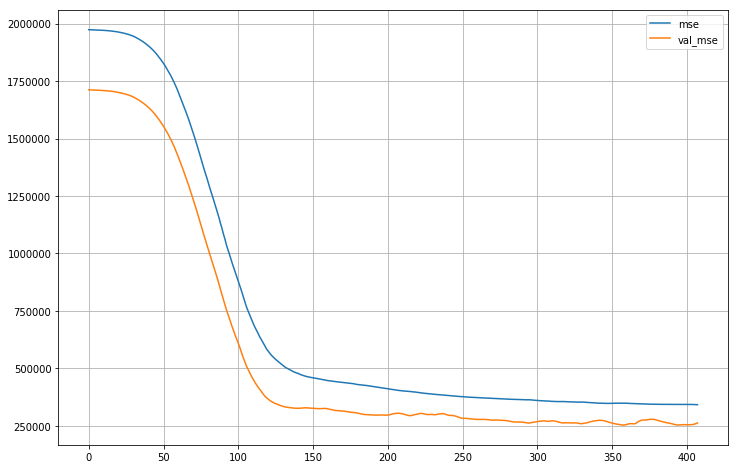

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
# 훈련 데이터의 mse
plt.plot(history.history['mean_squared_error'])
# 검증 데이터의 mse
plt.plot(history.history['val_mean_squared_error'])
plt.legend(['mse','val_mse'])
plt.grid()
plt.show()


### 검증 결과 확인

In [23]:
import math

In [24]:
# loss, mae, rmse 결과 확인
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
# mae 및 mse 결과 확인
mae

484.587646484375

In [25]:
math.sqrt(mse)

600.5557842532199

In [26]:
model.save("linear_keras_sellout.h5")

### cars.csv 파일을 활용하여 DNN(Deep Neural Network) 예측을 해보세요

In [27]:
carsData=pd.read_csv("./dataset/cars.csv")
carsData.head()

,age,gender,miles,debt,income,sales
0,28,0,23,0,4099,620
1,26,0,27,0,2677,1792
2,30,1,58,41576,6215,27754
3,26,1,25,43172,7626,28256
4,20,1,17,6979,8071,4438


In [28]:
sortKey = ["age","miles","debt","income","sales"]
carsData = carsData.sort_values(sortKey)
carsData.head()

,age,gender,miles,debt,income,sales
417,19,0,10,5387,1735,1728
822,19,0,15,5079,0,4491
533,19,1,15,9013,11048,4827
551,19,0,16,1592,2962,2993
711,19,1,16,2584,0,3412


In [29]:
corrdf=carsData.corr()
corrdf

,age,gender,miles,debt,income,sales
age,1.000000,-0.000702,0.232399,0.218896,0.239644,0.352609
gender,-0.000702,1.000000,-0.031355,-0.033181,-0.034317,-0.036350
miles,0.232399,-0.031355,1.000000,0.544791,0.422141,0.636676
debt,0.218896,-0.033181,0.544791,1.000000,0.491790,0.835541
income,0.239644,-0.034317,0.422141,0.491790,1.000000,0.674685
sales,0.352609,-0.036350,0.636676,0.835541,0.674685,1.000000


In [30]:
featuresStd = 0.5
features = list(corrdf[abs(corrdf.sales) > featuresStd].index)
features

['miles', 'debt', 'income', 'sales']

In [31]:
from sklearn.model_selection import train_test_split
### feature, label 컬럼 설정
featuresCol=features
labelCol=['sales']
### feature데이터, label데이터 분리
featuresData=carsData[featuresCol]
labelData=carsData[labelCol]
### train_test_split 함수를 활용해 feature / label 데이터 자동 분리 7:3
feature_train, feature_test, label_train, label_test = \
train_test_split(featuresData, labelData, test_size = 0.3)
def norm(x):
  return (x / x.max()) ## 컬럼마다 크기의 정도가 달라서 0~1사이로 맞춰줌
normed_train_data = norm(feature_train)
normed_test_data = norm(feature_test)


In [32]:
normed_train_data.head()

,miles,debt,income,sales
140,0.216495,0.147591,0.000000,0.116020
672,0.742268,0.934192,0.856892,0.973668
596,0.175258,0.049231,0.221470,0.359119
72,0.907216,0.891375,0.656140,0.928958
59,0.340206,0.894724,0.514787,0.868676


In [33]:
normed_test_data.head()

,miles,debt,income,sales
490,0.263158,0.000218,0.354109,0.132868
407,0.347368,0.118404,0.452878,0.418655
832,0.389474,0.901640,0.781603,0.791515
599,0.242105,0.011511,0.360057,0.177820
535,0.200000,0.157136,0.200050,0.322449


In [34]:
n_cols=len(features)

In [35]:
from keras import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(n_cols,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [36]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=[len(features)]),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
  ])

  #optimizer = keras.optimizers.RMSprop(0.001)
  optimizer = keras.optimizers.Adam()
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [37]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [38]:
early_stopping_monitor = EarlyStopping(patience=50)
EPOCHS = 2000    ##몇번을 훈련 시킬 것인가

In [39]:
#모델 훈련 (훈련/검증을 80%, 20%로 나눔)
history =model.fit(normed_train_data, label_train, validation_split=0.2, epochs= EPOCHS, callbacks=[early_stopping_monitor])

loss, mae, mse = model.evaluate(normed_test_data, label_test, verbose=0)


Train on 539 samples, validate on 135 samples
Epoch 1/2000
539/539 [==============================] - 0s 427us/step - loss: 222151141.2839 - mean_absolute_error: 11767.8095 - mean_squared_error: 222151141.2839 - val_loss: 222386727.8222 - val_mean_absolute_error: 11966.2289 - val_mean_squared_error: 222386727.8222
Epoch 2/2000
539/539 [==============================] - 0s 28us/step - loss: 222131351.3915 - mean_absolute_error: 11767.1556 - mean_squared_error: 222131351.3915 - val_loss: 222361397.3333 - val_mean_absolute_error: 11965.3922 - val_mean_squared_error: 222361397.3333
Epoch 3/2000
539/539 [==============================] - 0s 28us/step - loss: 222097881.1132 - mean_absolute_error: 11766.0438 - mean_squared_error: 222097881.1132 - val_loss: 222315835.0222 - val_mean_absolute_error: 11963.8603 - val_mean_squared_error: 222315835.0222
Epoch 4/2000
539/539 [==============================] - 0s 28us/step - loss: 222036343.2727 - mean_absolute_error: 11763.9798 - mean_squared_error

539/539 [==============================] - 0s 26us/step - loss: 146569388.2894 - mean_absolute_error: 9102.7730 - mean_squared_error: 146569388.2894 - val_loss: 143926733.0370 - val_mean_absolute_error: 9129.8208 - val_mean_squared_error: 143926733.0370
Epoch 32/2000
539/539 [==============================] - 0s 26us/step - loss: 140300327.9258 - mean_absolute_error: 8876.3918 - mean_squared_error: 140300327.9258 - val_loss: 137663967.1704 - val_mean_absolute_error: 8894.6646 - val_mean_squared_error: 137663967.1704
Epoch 33/2000
539/539 [==============================] - 0s 30us/step - loss: 133957673.6327 - mean_absolute_error: 8644.6931 - mean_squared_error: 133957673.6327 - val_loss: 131273591.5852 - val_mean_absolute_error: 8656.2568 - val_mean_squared_error: 131273591.5852
Epoch 34/2000
539/539 [==============================] - 0s 28us/step - loss: 127488780.4824 - mean_absolute_error: 8407.8787 - mean_squared_error: 127488780.4824 - val_loss: 124872889.8370 - val_mean_absolute_

Epoch 62/2000
539/539 [==============================] - 0s 28us/step - loss: 24962497.6660 - mean_absolute_error: 4467.0434 - mean_squared_error: 24962497.6660 - val_loss: 25185787.7333 - val_mean_absolute_error: 4504.0508 - val_mean_squared_error: 25185787.7333
Epoch 63/2000
539/539 [==============================] - 0s 32us/step - loss: 24464419.3544 - mean_absolute_error: 4423.2254 - mean_squared_error: 24464419.3544 - val_loss: 24727632.8741 - val_mean_absolute_error: 4462.9240 - val_mean_squared_error: 24727632.8741
Epoch 64/2000
539/539 [==============================] - 0s 28us/step - loss: 24050323.9685 - mean_absolute_error: 4385.9303 - mean_squared_error: 24050323.9685 - val_loss: 24318886.2519 - val_mean_absolute_error: 4423.7411 - val_mean_squared_error: 24318886.2519
Epoch 65/2000
539/539 [==============================] - 0s 28us/step - loss: 23679328.2894 - mean_absolute_error: 4347.9681 - mean_squared_error: 23679328.2894 - val_loss: 23971392.7407 - val_mean_absolute_e

539/539 [==============================] - 0s 28us/step - loss: 18135596.5399 - mean_absolute_error: 3709.5739 - mean_squared_error: 18135596.5399 - val_loss: 18520510.9556 - val_mean_absolute_error: 3787.5428 - val_mean_squared_error: 18520510.9556
Epoch 94/2000
539/539 [==============================] - 0s 28us/step - loss: 17959611.6994 - mean_absolute_error: 3690.0292 - mean_squared_error: 17959611.6994 - val_loss: 18352845.8148 - val_mean_absolute_error: 3769.4002 - val_mean_squared_error: 18352845.8148
Epoch 95/2000
539/539 [==============================] - 0s 28us/step - loss: 17786925.3840 - mean_absolute_error: 3671.1095 - mean_squared_error: 17786925.3840 - val_loss: 18186712.4370 - val_mean_absolute_error: 3753.4166 - val_mean_squared_error: 18186712.4370
Epoch 96/2000
539/539 [==============================] - 0s 28us/step - loss: 17610928.6605 - mean_absolute_error: 3651.6770 - mean_squared_error: 17610928.6605 - val_loss: 18018514.9407 - val_mean_absolute_error: 3734.655

Epoch 124/2000
539/539 [==============================] - 0s 26us/step - loss: 13018327.6883 - mean_absolute_error: 3082.1365 - mean_squared_error: 13018327.6883 - val_loss: 13512109.4000 - val_mean_absolute_error: 3200.2955 - val_mean_squared_error: 13512109.4000
Epoch 125/2000
539/539 [==============================] - 0s 28us/step - loss: 12866784.0501 - mean_absolute_error: 3063.2614 - mean_squared_error: 12866784.0501 - val_loss: 13367186.6593 - val_mean_absolute_error: 3182.6659 - val_mean_squared_error: 13367186.6593
Epoch 126/2000
539/539 [==============================] - 0s 26us/step - loss: 12714673.0668 - mean_absolute_error: 3043.2511 - mean_squared_error: 12714673.0668 - val_loss: 13218587.0667 - val_mean_absolute_error: 3163.4656 - val_mean_squared_error: 13218587.0667
Epoch 127/2000
539/539 [==============================] - 0s 28us/step - loss: 12564766.6215 - mean_absolute_error: 3024.7211 - mean_squared_error: 12564766.6215 - val_loss: 13076489.7778 - val_mean_absolu

539/539 [==============================] - 0s 30us/step - loss: 8941685.1113 - mean_absolute_error: 2507.0096 - mean_squared_error: 8941685.1113 - val_loss: 9475318.8593 - val_mean_absolute_error: 2625.1464 - val_mean_squared_error: 9475318.8593
Epoch 156/2000
539/539 [==============================] - 0s 26us/step - loss: 8830665.7403 - mean_absolute_error: 2489.3960 - mean_squared_error: 8830665.7403 - val_loss: 9365348.3185 - val_mean_absolute_error: 2606.9737 - val_mean_squared_error: 9365348.3185
Epoch 157/2000
539/539 [==============================] - 0s 28us/step - loss: 8727179.7913 - mean_absolute_error: 2473.0074 - mean_squared_error: 8727179.7913 - val_loss: 9265349.4667 - val_mean_absolute_error: 2591.8400 - val_mean_squared_error: 9265349.4667
Epoch 158/2000
539/539 [==============================] - 0s 28us/step - loss: 8619596.2662 - mean_absolute_error: 2455.7610 - mean_squared_error: 8619596.2662 - val_loss: 9156614.5481 - val_mean_absolute_error: 2573.9827 - val_mean

539/539 [==============================] - 0s 32us/step - loss: 6334337.1085 - mean_absolute_error: 2053.3580 - mean_squared_error: 6334337.1085 - val_loss: 6837078.2852 - val_mean_absolute_error: 2168.9297 - val_mean_squared_error: 6837078.2852
Epoch 187/2000
539/539 [==============================] - 0s 28us/step - loss: 6275787.5881 - mean_absolute_error: 2041.9636 - mean_squared_error: 6275787.5881 - val_loss: 6774451.3444 - val_mean_absolute_error: 2156.2154 - val_mean_squared_error: 6774451.3444
Epoch 188/2000
539/539 [==============================] - 0s 30us/step - loss: 6216660.8952 - mean_absolute_error: 2030.2430 - mean_squared_error: 6216660.8952 - val_loss: 6714244.7630 - val_mean_absolute_error: 2143.8211 - val_mean_squared_error: 6714244.7630
Epoch 189/2000
539/539 [==============================] - 0s 26us/step - loss: 6158775.6317 - mean_absolute_error: 2018.5938 - mean_squared_error: 6158775.6317 - val_loss: 6653222.5778 - val_mean_absolute_error: 2131.8421 - val_mean

539/539 [==============================] - 0s 28us/step - loss: 4984698.2890 - mean_absolute_error: 1758.2778 - mean_squared_error: 4984698.2890 - val_loss: 5405118.7852 - val_mean_absolute_error: 1859.1442 - val_mean_squared_error: 5405118.7852
Epoch 218/2000
539/539 [==============================] - 0s 30us/step - loss: 4952999.4768 - mean_absolute_error: 1749.6709 - mean_squared_error: 4952999.4768 - val_loss: 5373600.3037 - val_mean_absolute_error: 1851.7392 - val_mean_squared_error: 5373600.3037
Epoch 219/2000
539/539 [==============================] - 0s 32us/step - loss: 4921870.5714 - mean_absolute_error: 1742.4838 - mean_squared_error: 4921870.5714 - val_loss: 5333030.0926 - val_mean_absolute_error: 1845.0377 - val_mean_squared_error: 5333030.0926
Epoch 220/2000
539/539 [==============================] - 0s 28us/step - loss: 4894540.5227 - mean_absolute_error: 1735.6537 - mean_squared_error: 4894540.5227 - val_loss: 5296681.8889 - val_mean_absolute_error: 1837.2911 - val_mean

539/539 [==============================] - 0s 28us/step - loss: 4156203.0867 - mean_absolute_error: 1561.1039 - mean_squared_error: 4156203.0867 - val_loss: 4483346.4630 - val_mean_absolute_error: 1661.8831 - val_mean_squared_error: 4483346.4630
Epoch 249/2000
539/539 [==============================] - 0s 26us/step - loss: 4132410.0046 - mean_absolute_error: 1556.9422 - mean_squared_error: 4132410.0046 - val_loss: 4458377.5296 - val_mean_absolute_error: 1656.3951 - val_mean_squared_error: 4458377.5296
Epoch 250/2000
539/539 [==============================] - 0s 28us/step - loss: 4107360.8729 - mean_absolute_error: 1551.4363 - mean_squared_error: 4107360.8729 - val_loss: 4428778.7074 - val_mean_absolute_error: 1650.7216 - val_mean_squared_error: 4428778.7074
Epoch 251/2000
539/539 [==============================] - 0s 26us/step - loss: 4085856.2992 - mean_absolute_error: 1546.6239 - mean_squared_error: 4085856.2992 - val_loss: 4404534.3889 - val_mean_absolute_error: 1644.9447 - val_mean

539/539 [==============================] - 0s 28us/step - loss: 3409183.1577 - mean_absolute_error: 1401.2368 - mean_squared_error: 3409183.1577 - val_loss: 3665489.8185 - val_mean_absolute_error: 1492.7098 - val_mean_squared_error: 3665489.8185
Epoch 280/2000
539/539 [==============================] - 0s 30us/step - loss: 3397194.5995 - mean_absolute_error: 1398.5535 - mean_squared_error: 3397194.5995 - val_loss: 3619346.1593 - val_mean_absolute_error: 1485.1281 - val_mean_squared_error: 3619346.1593
Epoch 281/2000
539/539 [==============================] - 0s 28us/step - loss: 3361197.6127 - mean_absolute_error: 1390.1635 - mean_squared_error: 3361197.6127 - val_loss: 3610403.8296 - val_mean_absolute_error: 1481.3470 - val_mean_squared_error: 3610403.8296
Epoch 282/2000
539/539 [==============================] - 0s 28us/step - loss: 3336701.7403 - mean_absolute_error: 1384.9411 - mean_squared_error: 3336701.7403 - val_loss: 3582041.1259 - val_mean_absolute_error: 1475.5477 - val_mean

539/539 [==============================] - 0s 26us/step - loss: 2662218.5473 - mean_absolute_error: 1233.0701 - mean_squared_error: 2662218.5473 - val_loss: 2842691.7407 - val_mean_absolute_error: 1310.8289 - val_mean_squared_error: 2842691.7407
Epoch 311/2000
539/539 [==============================] - 0s 28us/step - loss: 2639727.2090 - mean_absolute_error: 1227.3774 - mean_squared_error: 2639727.2090 - val_loss: 2817036.9500 - val_mean_absolute_error: 1304.7305 - val_mean_squared_error: 2817036.9500
Epoch 312/2000
539/539 [==============================] - 0s 28us/step - loss: 2615917.2505 - mean_absolute_error: 1221.1325 - mean_squared_error: 2615917.2505 - val_loss: 2794866.1000 - val_mean_absolute_error: 1299.1080 - val_mean_squared_error: 2794866.1000
Epoch 313/2000
539/539 [==============================] - 0s 30us/step - loss: 2594092.6664 - mean_absolute_error: 1217.0424 - mean_squared_error: 2594092.6664 - val_loss: 2755521.8667 - val_mean_absolute_error: 1290.9390 - val_mean

539/539 [==============================] - 0s 28us/step - loss: 1947441.2749 - mean_absolute_error: 1050.9343 - mean_squared_error: 1947441.2749 - val_loss: 2058981.5722 - val_mean_absolute_error: 1112.3191 - val_mean_squared_error: 2058981.5722
Epoch 342/2000
539/539 [==============================] - 0s 26us/step - loss: 1933292.9555 - mean_absolute_error: 1046.2155 - mean_squared_error: 1933292.9555 - val_loss: 2053888.7056 - val_mean_absolute_error: 1109.2834 - val_mean_squared_error: 2053888.7056
Epoch 343/2000
539/539 [==============================] - 0s 26us/step - loss: 1901948.0765 - mean_absolute_error: 1036.8633 - mean_squared_error: 1901948.0765 - val_loss: 2009786.0648 - val_mean_absolute_error: 1098.7787 - val_mean_squared_error: 2009786.0648
Epoch 344/2000
539/539 [==============================] - 0s 26us/step - loss: 1880617.3878 - mean_absolute_error: 1032.2226 - mean_squared_error: 1880617.3878 - val_loss: 1983853.2296 - val_mean_absolute_error: 1091.5976 - val_mean

539/539 [==============================] - 0s 28us/step - loss: 1301342.8991 - mean_absolute_error: 856.7400 - mean_squared_error: 1301342.8991 - val_loss: 1369410.0981 - val_mean_absolute_error: 903.9161 - val_mean_squared_error: 1369410.0981
Epoch 373/2000
539/539 [==============================] - 0s 28us/step - loss: 1285407.8323 - mean_absolute_error: 851.1039 - mean_squared_error: 1285407.8323 - val_loss: 1351632.5352 - val_mean_absolute_error: 897.5169 - val_mean_squared_error: 1351632.5352
Epoch 374/2000
539/539 [==============================] - 0s 28us/step - loss: 1263654.4610 - mean_absolute_error: 844.0910 - mean_squared_error: 1263654.4610 - val_loss: 1323891.0935 - val_mean_absolute_error: 889.0516 - val_mean_squared_error: 1323891.0935
Epoch 375/2000
539/539 [==============================] - 0s 28us/step - loss: 1244963.9770 - mean_absolute_error: 837.3779 - mean_squared_error: 1244963.9770 - val_loss: 1303785.6593 - val_mean_absolute_error: 882.0964 - val_mean_squared

Epoch 404/2000
539/539 [==============================] - 0s 28us/step - loss: 745714.6240 - mean_absolute_error: 648.0217 - mean_squared_error: 745714.6240 - val_loss: 776949.4574 - val_mean_absolute_error: 678.2582 - val_mean_squared_error: 776949.4574
Epoch 405/2000
539/539 [==============================] - 0s 28us/step - loss: 730375.8633 - mean_absolute_error: 640.9838 - mean_squared_error: 730375.8633 - val_loss: 754873.4352 - val_mean_absolute_error: 668.9313 - val_mean_squared_error: 754873.4352
Epoch 406/2000
539/539 [==============================] - 0s 28us/step - loss: 715263.9414 - mean_absolute_error: 634.2908 - mean_squared_error: 715263.9414 - val_loss: 741268.5231 - val_mean_absolute_error: 662.6742 - val_mean_squared_error: 741268.5231
Epoch 407/2000
539/539 [==============================] - 0s 28us/step - loss: 700598.3760 - mean_absolute_error: 628.0333 - mean_squared_error: 700598.3760 - val_loss: 731201.1639 - val_mean_absolute_error: 657.4867 - val_mean_squared

539/539 [==============================] - 0s 28us/step - loss: 344516.0964 - mean_absolute_error: 440.1437 - mean_squared_error: 344516.0964 - val_loss: 352520.4315 - val_mean_absolute_error: 455.1896 - val_mean_squared_error: 352520.4315
Epoch 437/2000
539/539 [==============================] - 0s 26us/step - loss: 333792.4218 - mean_absolute_error: 433.7125 - mean_squared_error: 333792.4218 - val_loss: 343165.6032 - val_mean_absolute_error: 448.9471 - val_mean_squared_error: 343165.6032
Epoch 438/2000
539/539 [==============================] - 0s 28us/step - loss: 324963.4169 - mean_absolute_error: 428.1198 - mean_squared_error: 324963.4169 - val_loss: 332863.1366 - val_mean_absolute_error: 442.1623 - val_mean_squared_error: 332863.1366
Epoch 439/2000
539/539 [==============================] - 0s 28us/step - loss: 314698.5287 - mean_absolute_error: 420.8812 - mean_squared_error: 314698.5287 - val_loss: 320720.4875 - val_mean_absolute_error: 434.0862 - val_mean_squared_error: 320720.

539/539 [==============================] - 0s 28us/step - loss: 114587.7278 - mean_absolute_error: 253.8237 - mean_squared_error: 114587.7278 - val_loss: 116382.8105 - val_mean_absolute_error: 259.6677 - val_mean_squared_error: 116382.8105
Epoch 469/2000
539/539 [==============================] - 0s 28us/step - loss: 110432.2908 - mean_absolute_error: 249.2315 - mean_squared_error: 110432.2908 - val_loss: 111012.1709 - val_mean_absolute_error: 253.4739 - val_mean_squared_error: 111012.1709
Epoch 470/2000
539/539 [==============================] - 0s 26us/step - loss: 106249.3928 - mean_absolute_error: 245.4483 - mean_squared_error: 106249.3928 - val_loss: 108423.7330 - val_mean_absolute_error: 250.3662 - val_mean_squared_error: 108423.7330
Epoch 471/2000
539/539 [==============================] - 0s 26us/step - loss: 101082.7339 - mean_absolute_error: 238.7661 - mean_squared_error: 101082.7339 - val_loss: 101510.2722 - val_mean_absolute_error: 242.1394 - val_mean_squared_error: 101510.

Epoch 501/2000
539/539 [==============================] - 0s 28us/step - loss: 22783.0264 - mean_absolute_error: 113.1480 - mean_squared_error: 22783.0264 - val_loss: 23312.5170 - val_mean_absolute_error: 113.3202 - val_mean_squared_error: 23312.5170
Epoch 502/2000
539/539 [==============================] - 0s 26us/step - loss: 21439.1834 - mean_absolute_error: 109.8719 - mean_squared_error: 21439.1834 - val_loss: 22144.7714 - val_mean_absolute_error: 110.2068 - val_mean_squared_error: 22144.7714
Epoch 503/2000
539/539 [==============================] - 0s 28us/step - loss: 20157.1431 - mean_absolute_error: 106.7078 - mean_squared_error: 20157.1431 - val_loss: 21113.2379 - val_mean_absolute_error: 107.4507 - val_mean_squared_error: 21113.2379
Epoch 504/2000
539/539 [==============================] - 0s 28us/step - loss: 19021.8928 - mean_absolute_error: 103.6996 - mean_squared_error: 19021.8928 - val_loss: 19912.8966 - val_mean_absolute_error: 104.1714 - val_mean_squared_error: 19912.8

539/539 [==============================] - 0s 28us/step - loss: 2413.5239 - mean_absolute_error: 36.4706 - mean_squared_error: 2413.5239 - val_loss: 3322.8087 - val_mean_absolute_error: 36.8207 - val_mean_squared_error: 3322.8087
Epoch 535/2000
539/539 [==============================] - 0s 28us/step - loss: 2232.5449 - mean_absolute_error: 34.8227 - mean_squared_error: 2232.5449 - val_loss: 3128.8064 - val_mean_absolute_error: 35.3238 - val_mean_squared_error: 3128.8064
Epoch 536/2000
539/539 [==============================] - 0s 26us/step - loss: 2057.5657 - mean_absolute_error: 33.6282 - mean_squared_error: 2057.5657 - val_loss: 2990.3880 - val_mean_absolute_error: 34.3461 - val_mean_squared_error: 2990.3880
Epoch 537/2000
539/539 [==============================] - 0s 28us/step - loss: 1911.9935 - mean_absolute_error: 32.2493 - mean_squared_error: 1911.9935 - val_loss: 2797.2552 - val_mean_absolute_error: 32.6496 - val_mean_squared_error: 2797.2552
Epoch 538/2000
539/539 [===========

Epoch 568/2000
539/539 [==============================] - 0s 30us/step - loss: 159.2919 - mean_absolute_error: 7.3533 - mean_squared_error: 159.2919 - val_loss: 887.7808 - val_mean_absolute_error: 8.4156 - val_mean_squared_error: 887.7808
Epoch 569/2000
539/539 [==============================] - 0s 28us/step - loss: 149.1519 - mean_absolute_error: 6.9558 - mean_squared_error: 149.1519 - val_loss: 873.3976 - val_mean_absolute_error: 8.1990 - val_mean_squared_error: 873.3976
Epoch 570/2000
539/539 [==============================] - 0s 26us/step - loss: 139.8388 - mean_absolute_error: 6.7050 - mean_squared_error: 139.8388 - val_loss: 858.7102 - val_mean_absolute_error: 7.7512 - val_mean_squared_error: 858.7102
Epoch 571/2000
539/539 [==============================] - 0s 26us/step - loss: 131.4031 - mean_absolute_error: 6.2633 - mean_squared_error: 131.4031 - val_loss: 846.2271 - val_mean_absolute_error: 7.4599 - val_mean_squared_error: 846.2271
Epoch 572/2000
539/539 [====================

539/539 [==============================] - 0s 28us/step - loss: 51.4733 - mean_absolute_error: 1.5206 - mean_squared_error: 51.4733 - val_loss: 663.2862 - val_mean_absolute_error: 3.3053 - val_mean_squared_error: 663.2862
Epoch 603/2000
539/539 [==============================] - 0s 28us/step - loss: 51.0132 - mean_absolute_error: 1.7006 - mean_squared_error: 51.0132 - val_loss: 660.2187 - val_mean_absolute_error: 3.1169 - val_mean_squared_error: 660.2187
Epoch 604/2000
539/539 [==============================] - 0s 28us/step - loss: 50.3477 - mean_absolute_error: 1.5076 - mean_squared_error: 50.3477 - val_loss: 657.3305 - val_mean_absolute_error: 3.2786 - val_mean_squared_error: 657.3305
Epoch 605/2000
539/539 [==============================] - 0s 28us/step - loss: 49.8178 - mean_absolute_error: 1.6186 - mean_squared_error: 49.8178 - val_loss: 654.1245 - val_mean_absolute_error: 3.0827 - val_mean_squared_error: 654.1245
Epoch 606/2000
539/539 [==============================] - 0s 28us/s

Epoch 637/2000
539/539 [==============================] - 0s 28us/step - loss: 36.7552 - mean_absolute_error: 1.3347 - mean_squared_error: 36.7552 - val_loss: 576.3192 - val_mean_absolute_error: 2.8996 - val_mean_squared_error: 576.3192
Epoch 638/2000
539/539 [==============================] - 0s 26us/step - loss: 36.3543 - mean_absolute_error: 1.3021 - mean_squared_error: 36.3543 - val_loss: 573.7057 - val_mean_absolute_error: 2.9126 - val_mean_squared_error: 573.7057
Epoch 639/2000
539/539 [==============================] - 0s 28us/step - loss: 36.0169 - mean_absolute_error: 1.2663 - mean_squared_error: 36.0169 - val_loss: 572.0010 - val_mean_absolute_error: 2.9264 - val_mean_squared_error: 572.0010
Epoch 640/2000
539/539 [==============================] - 0s 26us/step - loss: 35.7545 - mean_absolute_error: 1.2238 - mean_squared_error: 35.7545 - val_loss: 571.4119 - val_mean_absolute_error: 2.7699 - val_mean_squared_error: 571.4119
Epoch 641/2000
539/539 [============================

539/539 [==============================] - 0s 28us/step - loss: 26.5267 - mean_absolute_error: 1.0361 - mean_squared_error: 26.5267 - val_loss: 504.0361 - val_mean_absolute_error: 2.6550 - val_mean_squared_error: 504.0361
Epoch 672/2000
539/539 [==============================] - 0s 28us/step - loss: 26.2525 - mean_absolute_error: 1.0324 - mean_squared_error: 26.2525 - val_loss: 502.4335 - val_mean_absolute_error: 2.7252 - val_mean_squared_error: 502.4335
Epoch 673/2000
539/539 [==============================] - 0s 28us/step - loss: 25.9979 - mean_absolute_error: 1.0795 - mean_squared_error: 25.9979 - val_loss: 500.0374 - val_mean_absolute_error: 2.6147 - val_mean_squared_error: 500.0374
Epoch 674/2000
539/539 [==============================] - 0s 30us/step - loss: 25.6798 - mean_absolute_error: 1.0456 - mean_squared_error: 25.6798 - val_loss: 497.9708 - val_mean_absolute_error: 2.6022 - val_mean_squared_error: 497.9708
Epoch 675/2000
539/539 [==============================] - 0s 32us/s

Epoch 706/2000
539/539 [==============================] - 0s 28us/step - loss: 18.5073 - mean_absolute_error: 0.8938 - mean_squared_error: 18.5073 - val_loss: 434.6946 - val_mean_absolute_error: 2.3663 - val_mean_squared_error: 434.6946
Epoch 707/2000
539/539 [==============================] - 0s 28us/step - loss: 18.3174 - mean_absolute_error: 0.9417 - mean_squared_error: 18.3174 - val_loss: 433.1506 - val_mean_absolute_error: 2.2792 - val_mean_squared_error: 433.1506
Epoch 708/2000
539/539 [==============================] - 0s 30us/step - loss: 18.0354 - mean_absolute_error: 0.8842 - mean_squared_error: 18.0354 - val_loss: 429.6183 - val_mean_absolute_error: 2.3456 - val_mean_squared_error: 429.6183
Epoch 709/2000
539/539 [==============================] - 0s 28us/step - loss: 17.7804 - mean_absolute_error: 0.8673 - mean_squared_error: 17.7804 - val_loss: 427.4223 - val_mean_absolute_error: 2.3550 - val_mean_squared_error: 427.4223
Epoch 710/2000
539/539 [============================

539/539 [==============================] - 0s 28us/step - loss: 12.2429 - mean_absolute_error: 0.9507 - mean_squared_error: 12.2429 - val_loss: 366.6732 - val_mean_absolute_error: 2.2014 - val_mean_squared_error: 366.6732
Epoch 741/2000
539/539 [==============================] - 0s 28us/step - loss: 11.8647 - mean_absolute_error: 0.7145 - mean_squared_error: 11.8647 - val_loss: 366.8630 - val_mean_absolute_error: 2.0285 - val_mean_squared_error: 366.8630
Epoch 742/2000
539/539 [==============================] - 0s 26us/step - loss: 11.6600 - mean_absolute_error: 0.7039 - mean_squared_error: 11.6600 - val_loss: 363.0420 - val_mean_absolute_error: 2.1069 - val_mean_squared_error: 363.0420
Epoch 743/2000
539/539 [==============================] - 0s 26us/step - loss: 11.4411 - mean_absolute_error: 0.7249 - mean_squared_error: 11.4411 - val_loss: 361.0646 - val_mean_absolute_error: 2.1234 - val_mean_squared_error: 361.0646
Epoch 744/2000
539/539 [==============================] - 0s 26us/s

Epoch 775/2000
539/539 [==============================] - 0s 28us/step - loss: 7.5160 - mean_absolute_error: 0.5645 - mean_squared_error: 7.5160 - val_loss: 310.6594 - val_mean_absolute_error: 1.8227 - val_mean_squared_error: 310.6594
Epoch 776/2000
539/539 [==============================] - 0s 28us/step - loss: 7.3708 - mean_absolute_error: 0.5413 - mean_squared_error: 7.3708 - val_loss: 309.4973 - val_mean_absolute_error: 1.8153 - val_mean_squared_error: 309.4973
Epoch 777/2000
539/539 [==============================] - 0s 28us/step - loss: 7.2590 - mean_absolute_error: 0.4822 - mean_squared_error: 7.2590 - val_loss: 308.1777 - val_mean_absolute_error: 1.7867 - val_mean_squared_error: 308.1777
Epoch 778/2000
539/539 [==============================] - 0s 28us/step - loss: 7.1639 - mean_absolute_error: 0.4755 - mean_squared_error: 7.1639 - val_loss: 307.1749 - val_mean_absolute_error: 1.9559 - val_mean_squared_error: 307.1749
Epoch 779/2000
539/539 [==============================] - 0s

Epoch 810/2000
539/539 [==============================] - 0s 26us/step - loss: 4.4323 - mean_absolute_error: 0.4022 - mean_squared_error: 4.4323 - val_loss: 262.4695 - val_mean_absolute_error: 1.6861 - val_mean_squared_error: 262.4695
Epoch 811/2000
539/539 [==============================] - 0s 26us/step - loss: 4.3841 - mean_absolute_error: 0.4286 - mean_squared_error: 4.3841 - val_loss: 261.9150 - val_mean_absolute_error: 1.7163 - val_mean_squared_error: 261.9150
Epoch 812/2000
539/539 [==============================] - 0s 26us/step - loss: 4.3016 - mean_absolute_error: 0.3945 - mean_squared_error: 4.3016 - val_loss: 260.3692 - val_mean_absolute_error: 1.7484 - val_mean_squared_error: 260.3692
Epoch 813/2000
539/539 [==============================] - 0s 26us/step - loss: 4.2496 - mean_absolute_error: 0.4326 - mean_squared_error: 4.2496 - val_loss: 259.3883 - val_mean_absolute_error: 1.6465 - val_mean_squared_error: 259.3883
Epoch 814/2000
539/539 [==============================] - 0s

Epoch 845/2000
539/539 [==============================] - 0s 28us/step - loss: 2.4485 - mean_absolute_error: 0.3395 - mean_squared_error: 2.4485 - val_loss: 222.1424 - val_mean_absolute_error: 1.4346 - val_mean_squared_error: 222.1424
Epoch 846/2000
539/539 [==============================] - 0s 28us/step - loss: 2.3970 - mean_absolute_error: 0.2865 - mean_squared_error: 2.3970 - val_loss: 221.7237 - val_mean_absolute_error: 1.4129 - val_mean_squared_error: 221.7237
Epoch 847/2000
539/539 [==============================] - 0s 28us/step - loss: 2.3704 - mean_absolute_error: 0.3022 - mean_squared_error: 2.3704 - val_loss: 220.0512 - val_mean_absolute_error: 1.4246 - val_mean_squared_error: 220.0512
Epoch 848/2000
539/539 [==============================] - 0s 30us/step - loss: 2.3017 - mean_absolute_error: 0.3016 - mean_squared_error: 2.3017 - val_loss: 219.0847 - val_mean_absolute_error: 1.4600 - val_mean_squared_error: 219.0847
Epoch 849/2000
539/539 [==============================] - 0s

Epoch 880/2000
539/539 [==============================] - 0s 30us/step - loss: 1.3798 - mean_absolute_error: 0.3437 - mean_squared_error: 1.3798 - val_loss: 191.7272 - val_mean_absolute_error: 1.3280 - val_mean_squared_error: 191.7272
Epoch 881/2000
539/539 [==============================] - 0s 28us/step - loss: 1.3421 - mean_absolute_error: 0.3165 - mean_squared_error: 1.3421 - val_loss: 191.0728 - val_mean_absolute_error: 1.4759 - val_mean_squared_error: 191.0728
Epoch 882/2000
539/539 [==============================] - 0s 28us/step - loss: 1.3181 - mean_absolute_error: 0.2980 - mean_squared_error: 1.3181 - val_loss: 190.8527 - val_mean_absolute_error: 1.3111 - val_mean_squared_error: 190.8527
Epoch 883/2000
539/539 [==============================] - 0s 28us/step - loss: 1.3164 - mean_absolute_error: 0.3288 - mean_squared_error: 1.3164 - val_loss: 190.2123 - val_mean_absolute_error: 1.4461 - val_mean_squared_error: 190.2123
Epoch 884/2000
539/539 [==============================] - 0s

Epoch 915/2000
539/539 [==============================] - 0s 32us/step - loss: 0.6967 - mean_absolute_error: 0.2297 - mean_squared_error: 0.6967 - val_loss: 169.5433 - val_mean_absolute_error: 1.4398 - val_mean_squared_error: 169.5433
Epoch 916/2000
539/539 [==============================] - 0s 30us/step - loss: 0.7353 - mean_absolute_error: 0.2606 - mean_squared_error: 0.7353 - val_loss: 169.2188 - val_mean_absolute_error: 1.2570 - val_mean_squared_error: 169.2188
Epoch 917/2000
539/539 [==============================] - 0s 26us/step - loss: 0.6922 - mean_absolute_error: 0.2124 - mean_squared_error: 0.6922 - val_loss: 168.6314 - val_mean_absolute_error: 1.2808 - val_mean_squared_error: 168.6314
Epoch 918/2000
539/539 [==============================] - 0s 26us/step - loss: 0.7020 - mean_absolute_error: 0.2557 - mean_squared_error: 0.7020 - val_loss: 168.0653 - val_mean_absolute_error: 1.3035 - val_mean_squared_error: 168.0653
Epoch 919/2000
539/539 [==============================] - 0s

Epoch 950/2000
539/539 [==============================] - 0s 28us/step - loss: 0.3741 - mean_absolute_error: 0.1843 - mean_squared_error: 0.3741 - val_loss: 152.0975 - val_mean_absolute_error: 1.2938 - val_mean_squared_error: 152.0975
Epoch 951/2000
539/539 [==============================] - 0s 28us/step - loss: 0.3680 - mean_absolute_error: 0.2167 - mean_squared_error: 0.3680 - val_loss: 151.3097 - val_mean_absolute_error: 1.2482 - val_mean_squared_error: 151.3097
Epoch 952/2000
539/539 [==============================] - 0s 28us/step - loss: 0.3538 - mean_absolute_error: 0.1687 - mean_squared_error: 0.3538 - val_loss: 150.9722 - val_mean_absolute_error: 1.1366 - val_mean_squared_error: 150.9722
Epoch 953/2000
539/539 [==============================] - 0s 28us/step - loss: 0.3393 - mean_absolute_error: 0.1607 - mean_squared_error: 0.3393 - val_loss: 150.4113 - val_mean_absolute_error: 1.2044 - val_mean_squared_error: 150.4113
Epoch 954/2000
539/539 [==============================] - 0s

Epoch 985/2000
539/539 [==============================] - 0s 28us/step - loss: 0.1983 - mean_absolute_error: 0.2056 - mean_squared_error: 0.1983 - val_loss: 138.0644 - val_mean_absolute_error: 1.1616 - val_mean_squared_error: 138.0644
Epoch 986/2000
539/539 [==============================] - 0s 26us/step - loss: 0.1952 - mean_absolute_error: 0.1945 - mean_squared_error: 0.1952 - val_loss: 137.6237 - val_mean_absolute_error: 1.1724 - val_mean_squared_error: 137.6237
Epoch 987/2000
539/539 [==============================] - 0s 28us/step - loss: 0.1734 - mean_absolute_error: 0.1615 - mean_squared_error: 0.1734 - val_loss: 137.2210 - val_mean_absolute_error: 1.0643 - val_mean_squared_error: 137.2210
Epoch 988/2000
539/539 [==============================] - 0s 26us/step - loss: 0.1554 - mean_absolute_error: 0.0999 - mean_squared_error: 0.1554 - val_loss: 136.9021 - val_mean_absolute_error: 1.1237 - val_mean_squared_error: 136.9021
Epoch 989/2000
539/539 [==============================] - 0s

Epoch 1020/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0787 - mean_absolute_error: 0.1121 - mean_squared_error: 0.0787 - val_loss: 128.0867 - val_mean_absolute_error: 1.2282 - val_mean_squared_error: 128.0867
Epoch 1021/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0988 - mean_absolute_error: 0.1656 - mean_squared_error: 0.0988 - val_loss: 127.8543 - val_mean_absolute_error: 1.0925 - val_mean_squared_error: 127.8543
Epoch 1022/2000
539/539 [==============================] - 0s 26us/step - loss: 0.0883 - mean_absolute_error: 0.1446 - mean_squared_error: 0.0883 - val_loss: 127.9055 - val_mean_absolute_error: 1.0850 - val_mean_squared_error: 127.9055
Epoch 1023/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0755 - mean_absolute_error: 0.1237 - mean_squared_error: 0.0755 - val_loss: 127.7481 - val_mean_absolute_error: 1.0863 - val_mean_squared_error: 127.7481
Epoch 1024/2000
539/539 [==============================]

Epoch 1055/2000
539/539 [==============================] - 0s 26us/step - loss: 0.0291 - mean_absolute_error: 0.0531 - mean_squared_error: 0.0291 - val_loss: 121.4330 - val_mean_absolute_error: 1.0019 - val_mean_squared_error: 121.4330
Epoch 1056/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0309 - mean_absolute_error: 0.0810 - mean_squared_error: 0.0309 - val_loss: 121.2339 - val_mean_absolute_error: 0.9953 - val_mean_squared_error: 121.2339
Epoch 1057/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0363 - mean_absolute_error: 0.0957 - mean_squared_error: 0.0363 - val_loss: 120.9416 - val_mean_absolute_error: 1.1389 - val_mean_squared_error: 120.9416
Epoch 1058/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0807 - mean_absolute_error: 0.2006 - mean_squared_error: 0.0807 - val_loss: 120.9635 - val_mean_absolute_error: 1.0585 - val_mean_squared_error: 120.9635
Epoch 1059/2000
539/539 [==============================]

Epoch 1090/2000
539/539 [==============================] - 0s 30us/step - loss: 0.1373 - mean_absolute_error: 0.2726 - mean_squared_error: 0.1373 - val_loss: 117.5105 - val_mean_absolute_error: 1.0224 - val_mean_squared_error: 117.5105
Epoch 1091/2000
539/539 [==============================] - 0s 30us/step - loss: 0.0146 - mean_absolute_error: 0.0628 - mean_squared_error: 0.0146 - val_loss: 118.0136 - val_mean_absolute_error: 1.1454 - val_mean_squared_error: 118.0136
Epoch 1092/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0743 - mean_absolute_error: 0.2042 - mean_squared_error: 0.0743 - val_loss: 117.3750 - val_mean_absolute_error: 1.1424 - val_mean_squared_error: 117.3750
Epoch 1093/2000
539/539 [==============================] - 0s 26us/step - loss: 0.0802 - mean_absolute_error: 0.1902 - mean_squared_error: 0.0802 - val_loss: 120.3075 - val_mean_absolute_error: 2.1016 - val_mean_squared_error: 120.3075
Epoch 1094/2000
539/539 [==============================]

Epoch 1125/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0070 - mean_absolute_error: 0.0303 - mean_squared_error: 0.0070 - val_loss: 116.5264 - val_mean_absolute_error: 0.9788 - val_mean_squared_error: 116.5264
Epoch 1126/2000
539/539 [==============================] - 0s 30us/step - loss: 0.0094 - mean_absolute_error: 0.0521 - mean_squared_error: 0.0094 - val_loss: 116.4390 - val_mean_absolute_error: 0.9437 - val_mean_squared_error: 116.4390
Epoch 1127/2000
539/539 [==============================] - 0s 30us/step - loss: 0.0083 - mean_absolute_error: 0.0374 - mean_squared_error: 0.0083 - val_loss: 116.5116 - val_mean_absolute_error: 0.9534 - val_mean_squared_error: 116.5116
Epoch 1128/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0069 - mean_absolute_error: 0.0343 - mean_squared_error: 0.0069 - val_loss: 116.5142 - val_mean_absolute_error: 0.9731 - val_mean_squared_error: 116.5142
Epoch 1129/2000
539/539 [==============================]

Epoch 1160/2000
539/539 [==============================] - 0s 28us/step - loss: 17.9604 - mean_absolute_error: 3.3258 - mean_squared_error: 17.9604 - val_loss: 122.1937 - val_mean_absolute_error: 2.9668 - val_mean_squared_error: 122.1937
Epoch 1161/2000
539/539 [==============================] - 0s 28us/step - loss: 3.3560 - mean_absolute_error: 1.4597 - mean_squared_error: 3.3560 - val_loss: 117.3240 - val_mean_absolute_error: 1.9330 - val_mean_squared_error: 117.3240
Epoch 1162/2000
539/539 [==============================] - 0s 26us/step - loss: 2.8278 - mean_absolute_error: 1.1320 - mean_squared_error: 2.8278 - val_loss: 114.7469 - val_mean_absolute_error: 1.3060 - val_mean_squared_error: 114.7469
Epoch 1163/2000
539/539 [==============================] - 0s 28us/step - loss: 0.1500 - mean_absolute_error: 0.3114 - mean_squared_error: 0.1500 - val_loss: 115.9603 - val_mean_absolute_error: 1.0837 - val_mean_squared_error: 115.9603
Epoch 1164/2000
539/539 [=============================

Epoch 1195/2000
539/539 [==============================] - 0s 26us/step - loss: 0.0062 - mean_absolute_error: 0.0535 - mean_squared_error: 0.0062 - val_loss: 114.8286 - val_mean_absolute_error: 0.9708 - val_mean_squared_error: 114.8286
Epoch 1196/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0094 - mean_absolute_error: 0.0647 - mean_squared_error: 0.0094 - val_loss: 114.8351 - val_mean_absolute_error: 0.9605 - val_mean_squared_error: 114.8351
Epoch 1197/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0061 - mean_absolute_error: 0.0488 - mean_squared_error: 0.0061 - val_loss: 115.0923 - val_mean_absolute_error: 1.1243 - val_mean_squared_error: 115.0923
Epoch 1198/2000
539/539 [==============================] - 0s 30us/step - loss: 0.0242 - mean_absolute_error: 0.1223 - mean_squared_error: 0.0242 - val_loss: 114.6556 - val_mean_absolute_error: 0.9711 - val_mean_squared_error: 114.6556
Epoch 1199/2000
539/539 [==============================]

539/539 [==============================] - 0s 28us/step - loss: 0.0022 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0022 - val_loss: 114.5681 - val_mean_absolute_error: 0.9292 - val_mean_squared_error: 114.5681
Epoch 1230/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0018 - mean_absolute_error: 0.0163 - mean_squared_error: 0.0018 - val_loss: 114.5376 - val_mean_absolute_error: 0.9367 - val_mean_squared_error: 114.5376
Epoch 1231/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0015 - mean_absolute_error: 0.0128 - mean_squared_error: 0.0015 - val_loss: 114.4566 - val_mean_absolute_error: 0.9365 - val_mean_squared_error: 114.4566
Epoch 1232/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0018 - mean_absolute_error: 0.0194 - mean_squared_error: 0.0018 - val_loss: 114.4172 - val_mean_absolute_error: 0.9302 - val_mean_squared_error: 114.4172
Epoch 1233/2000
539/539 [==============================] - 0s 28us/step 

Epoch 1264/2000
539/539 [==============================] - 0s 32us/step - loss: 0.0015 - mean_absolute_error: 0.0230 - mean_squared_error: 0.0015 - val_loss: 113.8148 - val_mean_absolute_error: 0.9296 - val_mean_squared_error: 113.8148
Epoch 1265/2000
539/539 [==============================] - 0s 30us/step - loss: 0.0014 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0014 - val_loss: 113.7874 - val_mean_absolute_error: 0.9352 - val_mean_squared_error: 113.7874
Epoch 1266/2000
539/539 [==============================] - 0s 28us/step - loss: 9.8274e-04 - mean_absolute_error: 0.0144 - mean_squared_error: 9.8274e-04 - val_loss: 113.8118 - val_mean_absolute_error: 0.9420 - val_mean_squared_error: 113.8118
Epoch 1267/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0014 - mean_absolute_error: 0.0230 - mean_squared_error: 0.0014 - val_loss: 113.7835 - val_mean_absolute_error: 0.9304 - val_mean_squared_error: 113.7835
Epoch 1268/2000
539/539 [=======================

Epoch 1299/2000
539/539 [==============================] - 0s 26us/step - loss: 0.1083 - mean_absolute_error: 0.2621 - mean_squared_error: 0.1083 - val_loss: 113.1927 - val_mean_absolute_error: 0.9806 - val_mean_squared_error: 113.1927
Epoch 1300/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0467 - mean_absolute_error: 0.1702 - mean_squared_error: 0.0467 - val_loss: 113.4529 - val_mean_absolute_error: 1.1231 - val_mean_squared_error: 113.4529
Epoch 1301/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0842 - mean_absolute_error: 0.2279 - mean_squared_error: 0.0842 - val_loss: 113.3638 - val_mean_absolute_error: 1.0377 - val_mean_squared_error: 113.3638
Epoch 1302/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0170 - mean_absolute_error: 0.0994 - mean_squared_error: 0.0170 - val_loss: 113.1689 - val_mean_absolute_error: 0.9857 - val_mean_squared_error: 113.1689
Epoch 1303/2000
539/539 [==============================]

539/539 [==============================] - 0s 28us/step - loss: 5.6238e-04 - mean_absolute_error: 0.0161 - mean_squared_error: 5.6238e-04 - val_loss: 113.0414 - val_mean_absolute_error: 0.9324 - val_mean_squared_error: 113.0414
Epoch 1334/2000
539/539 [==============================] - 0s 30us/step - loss: 3.0323e-04 - mean_absolute_error: 0.0091 - mean_squared_error: 3.0323e-04 - val_loss: 113.0478 - val_mean_absolute_error: 0.9238 - val_mean_squared_error: 113.0478
Epoch 1335/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0046 - mean_absolute_error: 0.0463 - mean_squared_error: 0.0046 - val_loss: 112.9219 - val_mean_absolute_error: 1.1293 - val_mean_squared_error: 112.9219
Epoch 1336/2000
539/539 [==============================] - 0s 28us/step - loss: 0.3271 - mean_absolute_error: 0.4100 - mean_squared_error: 0.3271 - val_loss: 113.7796 - val_mean_absolute_error: 2.3757 - val_mean_squared_error: 113.7796
Epoch 1337/2000
539/539 [==============================]

In [40]:
history.history

{'loss': [222151141.28385898,
  222131351.39146566,
  222097881.11317253,
  222036343.27272728,
  221928505.17254174,
  221754076.7643785,
  221485437.4768089,
  221106274.7012987,
  220588036.21521336,
  219902899.94805196,
  219055986.34508348,
  217992596.66048238,
  216732959.6586271,
  215223871.52504638,
  213464239.3469388,
  211413266.7012987,
  209151808.2374768,
  206556874.41929498,
  203670494.54545453,
  200471412.51205936,
  197005213.3580705,
  193190167.6883117,
  189117074.9090909,
  184720848.62337664,
  179995730.15213358,
  175036966.85714287,
  169763099.16141,
  164311046.23376623,
  158570644.86827457,
  152633440.53432283,
  146569388.28942487,
  140300327.9257885,
  133957673.63265306,
  127488780.48237477,
  121158214.17439704,
  114570799.06493506,
  108178028.34879406,
  101789838.45640074,
  95758662.63450834,
  89528715.35435992,
  83601292.70500928,
  77906345.43970315,
  72631954.44897959,
  67384069.2244898,
  62545147.17625232,
  58052407.70315399,
  5

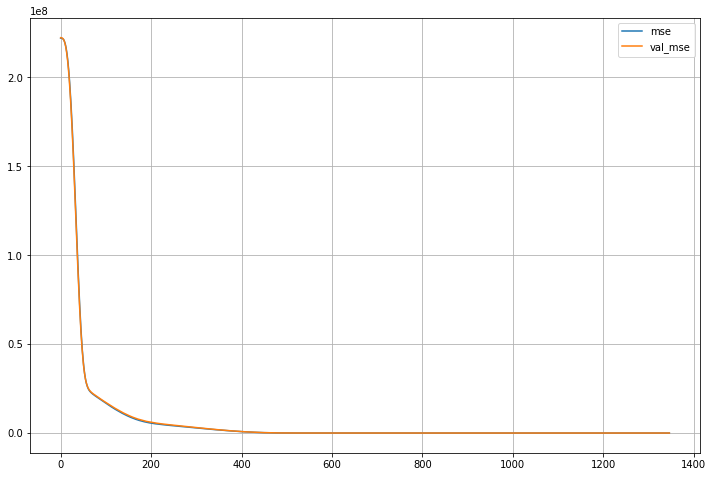

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
# 훈련 데이터의 mse
plt.plot(history.history['mean_squared_error'])
# 검증 데이터의 mse
plt.plot(history.history['val_mean_squared_error'])
plt.legend(['mse','val_mse'])
plt.grid()
plt.show()


In [42]:
loss, mae, mse = model.evaluate(normed_test_data, label_test, verbose=0)
# mae 및 mse 결과 확인
mae

96.2180724886462

In [43]:
len(label_test)

289

In [44]:
math.sqrt(mse)

120.94727661925872

In [45]:
import matplotlib.pyplot as plt

In [46]:
# 훈련 결과 중 마지막 5개를 확인
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
1342,114.132822,1.078668,114.132822,0.283856,0.402934,0.283856,1342
1343,113.024791,1.028734,113.024791,0.058326,0.192942,0.058326,1343
1344,113.274767,0.949990,113.274767,0.008273,0.069193,0.008273,1344
1345,113.199980,0.960175,113.199980,0.010252,0.073921,0.010252,1345
1346,113.086744,0.976856,113.086744,0.025328,0.124021,0.025328,1346


In [47]:
# 예측 수행
test_predictions = model.predict(normed_test_data).flatten()
test_predictions

array([ 3976.2798 , 12528.726  , 23686.947  ,  5321.516  ,  9649.686  ,
        6243.2134 ,  7660.0474 , 19965.854  ,  4796.127  ,  2355.7505 ,
       11153.226  ,  5535.32   , 28088.703  ,  6193.7964 , 10061.109  ,
       14191.606  , 18342.283  , 28465.861  ,  7464.414  , 23048.62   ,
        8181.384  ,  6155.468  , 20298.611  , 21257.633  ,  8404.284  ,
       22697.691  ,  7890.9736 , 25142.123  ,  4882.8467 ,  2893.2473 ,
        3410.5461 ,  2616.9375 ,  3482.1487 , 20811.904  , 27534.098  ,
       19771.242  ,  4647.9004 , 14113.948  , 24884.928  ,   718.0419 ,
       15956.324  ,  4894.921  ,  9952.1875 , 20600.17   ,  3226.0261 ,
       16028.94   , 15897.879  , 21813.283  ,  2941.6309 , 18345.285  ,
        4603.537  ,  1305.9966 , 10020.761  , 25194.535  , 28355.934  ,
        3192.7363 , 22716.818  , 22844.904  ,  5430.4336 ,  6092.961  ,
        9517.569  ,  1925.154  , 11497.09   ,  6346.073  , 20270.387  ,
       28645.377  , 29809.121  ,  6681.873  ,  9588.154  , 16944

In [48]:
# 예측결과 별도 데이터프레임 생성
predictValues = pd.DataFrame(list(test_predictions), columns = ["PREDICT"])

# 예측결과 컬럼 생성
finalResult2 = pd.concat([feature_test.reset_index(drop=True),predictValues.reset_index(drop=True)],axis=1)
finalResult2

,miles,debt,income,sales,PREDICT
0,25,13,4227,3943,3976.279785
1,33,7077,5406,12424,12528.725586
2,37,53891,9330,23489,23686.947266
3,23,688,4298,5277,5321.516113
4,19,9392,2388,9569,9649.685547
5,26,3571,5246,6191,6243.213379
6,18,9865,5563,7596,7660.047363
7,42,37524,9534,19799,19965.853516
8,10,5330,3593,4756,4796.126953
9,10,1777,1577,2336,2355.750488


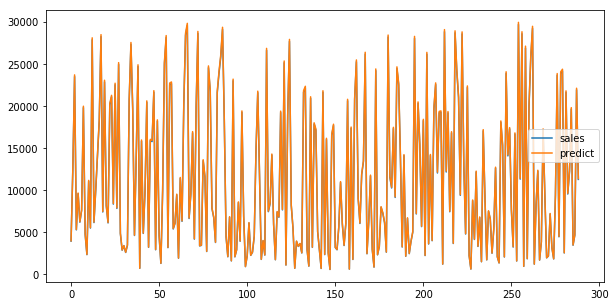

In [49]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.plot(finalResult2.sales, label = "sales")
plt.plot(finalResult2.PREDICT, label = "predict")
plt.legend(loc=0)

### 재학습



In [55]:
# 모델 저장
model_json = model.to_json()

with open("model.json","w")as json_file:
    json_file.write(model_json)

model.save_weights("linear_keras_sellout.h5")

In [63]:
# 모델 불러오기
from keras.models import model_from_json
json_file = open("model.json","r")
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("linear_keras_sellout.h5")  ##?????

In [58]:
# 모델 재 컴파일
optimizer = keras.optimizers.Adam()
loaded_model.compile(loss='mean_squared_error',optimizer=optimizer,metrics = \
                    ['mean_absolute_error','mean_squared_error'])
loaded_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [61]:
# 모델 재학습
early_stopping_monitor = EarlyStopping(patience=50)
EPOCHS = 2000    ##몇번을 훈련 시킬 것인가

#모델 훈련 (훈련/검증을 80%, 20%로 나눔)
history =loaded_model.fit(normed_train_data, label_train, validation_split=0.2, epochs= EPOCHS, callbacks=[early_stopping_monitor])

history.history

Train on 539 samples, validate on 135 samples
Epoch 1/2000
539/539 [==============================] - 0s 72us/step - loss: 2.5646e-04 - mean_absolute_error: 0.0085 - mean_squared_error: 2.5646e-04 - val_loss: 112.7278 - val_mean_absolute_error: 0.9269 - val_mean_squared_error: 112.7278
Epoch 2/2000
539/539 [==============================] - 0s 37us/step - loss: 2.6038e-04 - mean_absolute_error: 0.0097 - mean_squared_error: 2.6038e-04 - val_loss: 112.6567 - val_mean_absolute_error: 0.9210 - val_mean_squared_error: 112.6567
Epoch 3/2000
539/539 [==============================] - 0s 35us/step - loss: 1.2701e-04 - mean_absolute_error: 0.0054 - mean_squared_error: 1.2701e-04 - val_loss: 112.6167 - val_mean_absolute_error: 0.9240 - val_mean_squared_error: 112.6167
Epoch 4/2000
539/539 [==============================] - 0s 35us/step - loss: 9.8142e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 9.8142e-05 - val_loss: 112.5712 - val_mean_absolute_error: 0.9186 - val_mean_squared_error:

Epoch 35/2000
539/539 [==============================] - 0s 30us/step - loss: 0.0087 - mean_absolute_error: 0.0735 - mean_squared_error: 0.0087 - val_loss: 112.2777 - val_mean_absolute_error: 0.9621 - val_mean_squared_error: 112.2777
Epoch 36/2000
539/539 [==============================] - 0s 30us/step - loss: 0.0412 - mean_absolute_error: 0.1587 - mean_squared_error: 0.0412 - val_loss: 112.3314 - val_mean_absolute_error: 1.0369 - val_mean_squared_error: 112.3314
Epoch 37/2000
539/539 [==============================] - 0s 30us/step - loss: 0.0219 - mean_absolute_error: 0.1160 - mean_squared_error: 0.0219 - val_loss: 112.3547 - val_mean_absolute_error: 1.0223 - val_mean_squared_error: 112.3547
Epoch 38/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0232 - mean_absolute_error: 0.1199 - mean_squared_error: 0.0232 - val_loss: 112.6920 - val_mean_absolute_error: 1.1713 - val_mean_squared_error: 112.6920
Epoch 39/2000
539/539 [==============================] - 0s 28us

Epoch 70/2000
539/539 [==============================] - 0s 28us/step - loss: 0.3645 - mean_absolute_error: 0.4331 - mean_squared_error: 0.3645 - val_loss: 112.7712 - val_mean_absolute_error: 1.0574 - val_mean_squared_error: 112.7712
Epoch 71/2000
539/539 [==============================] - 0s 30us/step - loss: 0.4064 - mean_absolute_error: 0.4566 - mean_squared_error: 0.4064 - val_loss: 114.8694 - val_mean_absolute_error: 2.0355 - val_mean_squared_error: 114.8694
Epoch 72/2000
539/539 [==============================] - 0s 26us/step - loss: 6.3647 - mean_absolute_error: 1.9972 - mean_squared_error: 6.3647 - val_loss: 111.7255 - val_mean_absolute_error: 1.2220 - val_mean_squared_error: 111.7255
Epoch 73/2000
539/539 [==============================] - 0s 28us/step - loss: 7.0181 - mean_absolute_error: 2.0002 - mean_squared_error: 7.0181 - val_loss: 113.8570 - val_mean_absolute_error: 2.6665 - val_mean_squared_error: 113.8570
Epoch 74/2000
539/539 [==============================] - 0s 26us

539/539 [==============================] - 0s 28us/step - loss: 4.4369e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 4.4369e-05 - val_loss: 112.2864 - val_mean_absolute_error: 0.9188 - val_mean_squared_error: 112.2864
Epoch 105/2000
539/539 [==============================] - 0s 28us/step - loss: 1.9894e-05 - mean_absolute_error: 0.0019 - mean_squared_error: 1.9894e-05 - val_loss: 112.2872 - val_mean_absolute_error: 0.9168 - val_mean_squared_error: 112.2872
Epoch 106/2000
539/539 [==============================] - 0s 28us/step - loss: 2.7840e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 2.7840e-05 - val_loss: 112.2839 - val_mean_absolute_error: 0.9164 - val_mean_squared_error: 112.2839
Epoch 107/2000
539/539 [==============================] - 0s 28us/step - loss: 3.7983e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 3.7983e-05 - val_loss: 112.2949 - val_mean_absolute_error: 0.9274 - val_mean_squared_error: 112.2949
Epoch 108/2000
539/539 [===================

Epoch 139/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0024 - mean_absolute_error: 0.0388 - mean_squared_error: 0.0024 - val_loss: 112.2178 - val_mean_absolute_error: 0.9397 - val_mean_squared_error: 112.2178
Epoch 140/2000
539/539 [==============================] - 0s 28us/step - loss: 5.4245e-04 - mean_absolute_error: 0.0179 - mean_squared_error: 5.4245e-04 - val_loss: 112.1936 - val_mean_absolute_error: 0.9509 - val_mean_squared_error: 112.1936
Epoch 141/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0030 - mean_absolute_error: 0.0436 - mean_squared_error: 0.0030 - val_loss: 112.1927 - val_mean_absolute_error: 0.9218 - val_mean_squared_error: 112.1927
Epoch 142/2000
539/539 [==============================] - 0s 28us/step - loss: 8.0865e-04 - mean_absolute_error: 0.0222 - mean_squared_error: 8.0865e-04 - val_loss: 112.1855 - val_mean_absolute_error: 0.9263 - val_mean_squared_error: 112.1855
Epoch 143/2000
539/539 [====================

539/539 [==============================] - 0s 28us/step - loss: 0.0493 - mean_absolute_error: 0.1827 - mean_squared_error: 0.0493 - val_loss: 112.4665 - val_mean_absolute_error: 0.9808 - val_mean_squared_error: 112.4665
Epoch 174/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0145 - mean_absolute_error: 0.0905 - mean_squared_error: 0.0145 - val_loss: 112.6770 - val_mean_absolute_error: 0.9735 - val_mean_squared_error: 112.6770
Epoch 175/2000
539/539 [==============================] - 0s 28us/step - loss: 0.0025 - mean_absolute_error: 0.0374 - mean_squared_error: 0.0025 - val_loss: 112.6700 - val_mean_absolute_error: 0.9472 - val_mean_squared_error: 112.6700
Epoch 176/2000
539/539 [==============================] - 0s 30us/step - loss: 0.0016 - mean_absolute_error: 0.0310 - mean_squared_error: 0.0016 - val_loss: 112.5533 - val_mean_absolute_error: 0.9257 - val_mean_squared_error: 112.5533


{'loss': [0.00025646445215705624,
  0.0002603821586778626,
  0.00012700870664145993,
  9.814239283531199e-05,
  8.304630179343547e-05,
  8.388103669723548e-05,
  8.683791471506898e-05,
  8.872593191734805e-05,
  5.59791733259387e-05,
  0.0001010134944572167,
  6.896940609557918e-05,
  8.381249696052597e-05,
  0.00017841246341329659,
  6.920250966104437e-05,
  8.428139102734635e-05,
  8.49625921917471e-05,
  5.679163767933303e-05,
  4.781996536716084e-05,
  6.425413535664882e-05,
  4.4499881576667e-05,
  5.9894998073521724e-05,
  0.00010164358628505982,
  6.456668646754533e-05,
  0.00011258086122456655,
  0.00017781296124677403,
  6.957418855885735e-05,
  8.874577650200344e-05,
  0.0008408373421756118,
  0.0017393677390019836,
  0.00648012268140995,
  0.013796318274471694,
  0.01774420249249945,
  0.00724988015876575,
  0.012170251327565074,
  0.008732279620940257,
  0.041199219891722,
  0.021853318490202025,
  0.0232025513041882,
  0.08355344735182725,
  0.36992690296142133,
  0.665220